# Postwork Sesión 4

#### Objetivo

- Investigar la dependencia o independecia de las variables aleatorias X y Y, el número de goles anotados por el equipo de casa y el número de goles anotados por el equipo visitante.

#### Requisitos

- R, RStudio
- Haber trabajado con el prework y el work

#### Desarrollo

Ahora investigarás la dependencia o independencia del número de goles anotados por el equipo de casa y el número de goles anotados por el equipo visitante mediante un procedimiento denominado bootstrap, revisa bibliografía en internet para que tengas nociones de este desarrollo. 

1. Ya hemos estimado las probabilidades conjuntas de que el equipo de casa anote X=x goles (x=0,1,... ,8), y el equipo visitante anote Y=y goles (y=0,1,... ,6), en un partido. Obtén una tabla de cocientes al dividir estas probabilidades conjuntas por el producto de las probabilidades marginales correspondientes.

2. Mediante un procedimiento de boostrap, obtén más cocientes similares a los obtenidos en la tabla del punto anterior. Esto para tener una idea de las distribuciones de la cual vienen los cocientes en la tabla anterior. Menciona en cuáles casos le parece razonable suponer que los cocientes de la tabla en el punto 1, son iguales a 1 (en tal caso tendríamos independencia de las variables aleatorias X y Y).

__Notas para los datos de soccer:__ https://www.football-data.co.uk/notes.txt


#### Librerías utilizadas

In [13]:
library(dplyr)
library(rsample)
library(comprehenr)
library(data.table)
options(warn = -1)

#### Carga de datos
Primero procedemos a cargar los datos necesarios y su manipulación.

In [2]:
# Carga de datos
url_2017 <- "https://www.football-data.co.uk/mmz4281/1718/SP1.csv"
url_2018 <- "https://www.football-data.co.uk/mmz4281/1819/SP1.csv"
url_2019 <- "https://www.football-data.co.uk/mmz4281/1920/SP1.csv"
urls <- c(url_2017, url_2018, url_2019) 
lista <- lapply(urls, read.csv)

# Manipulando datos
lista <- lapply(lista, select, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR) # Variables de interés
lista <- lapply(lista, mutate, Date = as.Date(Date, format = "%d/%m/%y")) # Formato Date
datos <- do.call(rbind, lista) # Unimos los data frames

#### Solución 1

Creamos una función que nos calcule los cocientes $\frac{\mathbb{P}(X = x, Y = y)}{\mathbb{P}(X = x)\mathbb{P}(Y = y)}$ para cada para de observación $(x,y)$, esta función la reutilizaremos para la solución del ejercicio 2.

La columna $\textit{id_goles}$ es de la forma $x$_$y$ dónde $x$ son los goles del equipo de casa y $y$ los goles del equipo visitante.

In [3]:
cociente <- function(df){
    marginal_golescasa <- as.data.frame(table(df$FTHG)/length(df$FTHG)) # Marginal Casa
    names(marginal_golescasa) <- c("Goles", "Probabilidad")
    
    marginal_golesvis <- as.data.frame(table(df$FTAG)/length(df$FTAG)) # Marginal Visitante
    names(marginal_golesvis) <- c("Goles", "Probabilidad")
    
    conjunta_goles <- as.data.frame(table(df$FTHG, df$FTAG)/length(df$FTHG)) # Conjunta
    names(conjunta_goles) <- c("Goles_Casa", "Goles_Vis", "Probabilidad")

    # Cociente
    conjunta_goles <- merge(x = conjunta_goles, y = marginal_golescasa, by.x = "Goles_Casa", 
          by.y = "Goles", all.x = TRUE, suffixes = c("",".Casa")) 
    conjunta_goles <- merge(x = conjunta_goles, y = marginal_golesvis, by.x = "Goles_Vis", 
          by.y = "Goles", all.x = TRUE, suffixes = c("",".Vis"))
    conjunta_goles["Producto_Marginales"] =  conjunta_goles["Probabilidad.Casa"]*conjunta_goles["Probabilidad.Vis"] # Producto
    conjunta_goles["Cociente"] = conjunta_goles["Probabilidad"]/conjunta_goles["Producto_Marginales"] # Cociente
    conjunta_goles["id_goles"] = paste0(conjunta_goles[["Goles_Casa"]], "_", conjunta_goles[["Goles_Vis"]]) # (x,y)
    
    return(conjunta_goles[, c("id_goles", "Cociente")])
} 

In [4]:
head(cociente(datos), 5)

,id_goles,Cociente
,<chr>,<dbl>
1,0_0,0.9547829
2,3_0,1.1327151
3,1_0,1.0060639
4,7_0,0.0000000
5,4_0,1.1371571


In [5]:
str(cociente(datos))

'data.frame':	63 obs. of  2 variables:
 $ id_goles: chr  "0_0" "3_0" "1_0" "7_0" ...
 $ Cociente: num  0.955 1.133 1.006 0 1.137 ...


La media de los cocientes es 0.85 lo que nos puede dar una idea de que no hay independencia, más aún en el boxplot nos da indicios de varios valores atípicos, para poder confirmar que no hay independencia procederemos al ejercicio 2.

In [6]:
summary(cociente(datos)$Cociente)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.8814  0.8596  1.0777  4.7107 

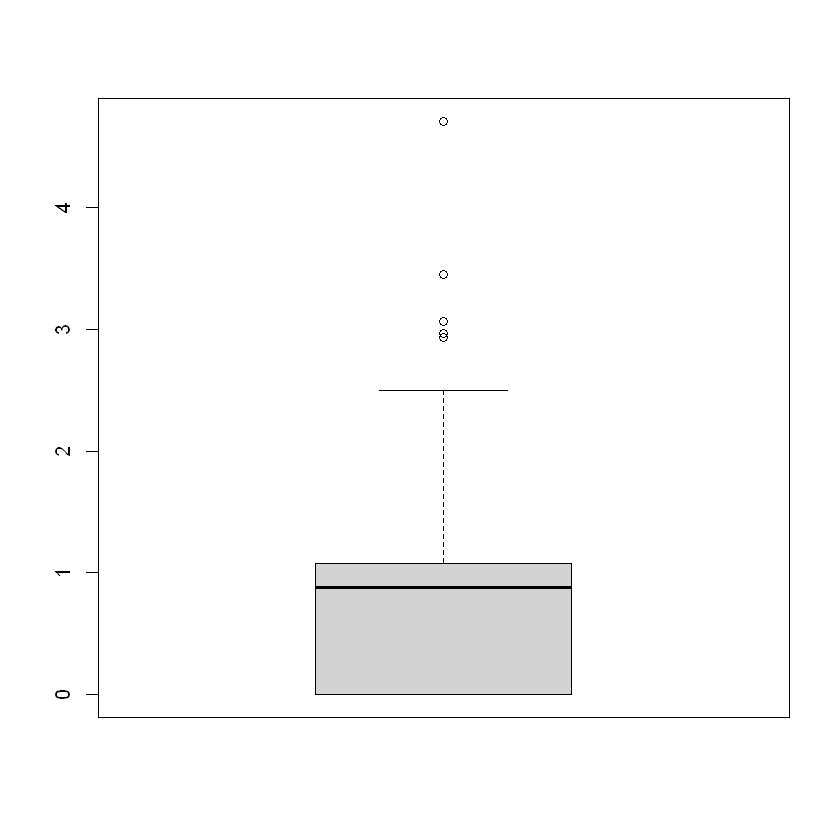

In [7]:
boxplot(cociente(datos)$Cociente)

#### Solución 2

Primero tomamos 1000 muestras bootstraps (Con remplazo).

$\textbf{Nota:}$ El objeto $\textit{datos_boot\$splits}$ es una lista con las 1000 muestras.

In [8]:
set.seed(25)
# Bootstrap con 1000 muestras
n_muestras = 1000
datos_boot <- bootstraps(datos, times = n_muestras)

# Mostramos la primera muestra para ejemplificar.
head(as.data.frame(datos_boot$splits[[1]]))

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
,<date>,<chr>,<chr>,<int>,<int>,<chr>
647,2020-03-10,Girona,Valencia,2,3,A
477,2020-10-28,Alaves,Villarreal,2,1,H
1073,2020-06-27,Celta,Barcelona,2,2,D
72,2017-10-14,Alaves,Sociedad,0,2,A
282,2018-03-17,Betis,Espanol,3,0,H
59,2017-09-24,Sociedad,Valencia,2,3,A


Ahora calculamos los cocientes $\frac{\mathbb{P}(X = x, Y = y)}{\mathbb{P}(X = x)\mathbb{P}(Y = y)}$ para cada una de las muestras obtenidas. 

$\textbf{Nota:}$ El data.frame $\textit{muestras}$ tiene como columnas los cocientes para cada observación $(x, y)$ y las filas son las muestras de ese cociente.

In [9]:
# Lista con los cocientes de cada muestra
muestras <- lapply(datos_boot$splits, function(x) cociente(as.data.frame(x))) 

# Juntando en un solo DF
muestras <- Reduce(function(x,y) merge(x, y, by = "id_goles", all = TRUE), muestras)

# Nombres de las columnas
names(muestras) <- c("id_goles", to_vec(for (i in 1:n_muestras) paste0("Muestra_", i)))

# Columnas del nuevo data frame 
nuevas_col <- to_vec(for(id in muestras$id_goles) paste0("Cociente_", id))

# Transponemos
muestras <- transpose(select(muestras, -id_goles))
names(muestras) <- nuevas_col

# Llenamos con cero los NA's
muestras[is.na(muestras)] <- 0 # Los eventos que no sucedieron tienen probabilidad cero
head(muestras)

,Cociente_0_0,Cociente_0_1,Cociente_0_2,Cociente_0_3,Cociente_0_4,Cociente_0_5,Cociente_0_6,Cociente_1_0,Cociente_1_1,Cociente_1_2,...,Cociente_7_4,Cociente_7_5,Cociente_7_6,Cociente_8_0,Cociente_8_1,Cociente_8_2,Cociente_8_3,Cociente_8_4,Cociente_8_5,Cociente_8_6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9085933,1.0531536,0.9030506,1.5455349,1.0191571,1.455939,0,0.9745939,1.0713176,0.9816585,...,0,0,0,0,0,4.810127,0,0,0,0
2,0.9774989,1.0579793,0.8674276,1.3906429,0.7089552,2.126866,0,1.0922230,1.0218887,0.9086561,...,0,0,0,0,0,4.470588,0,0,0,0
3,0.9006680,1.1379121,0.8800291,1.3394153,0.5219780,2.087912,0,1.1292289,0.9967617,0.8542800,...,0,0,0,0,0,4.710744,0,0,0,0
4,1.1015957,0.9050492,0.9482532,0.8421986,1.3078849,2.526596,0,0.9627346,1.0643832,0.8804157,...,0,0,0,0,0,4.691358,0,0,0,0
5,0.9359606,0.9364732,0.9235224,1.7441193,1.2119064,2.861446,0,0.9753695,1.0833333,0.9399142,...,0,0,0,0,0,4.892704,0,0,0,0
6,0.9456019,1.0345644,0.9334061,1.4843750,0.9375000,1.484375,0,0.9840410,0.9830007,1.1332410,...,0,0,0,0,0,0.000000,0,0,0,0


Se muestran los histogramas para unos cocientes, vemos que algunas distribuciones están centras cerca de 1 pero otras están muy alejadas de 1 ya sea a la izquierda o la derecha. El histograma que tiene solo un rectángulo grande, solo tiene valores cero lo que significa que el evento nunca sucedió, tiene sentido es muy raro que el equipo de casa anote cero goles y el visitante 6 cuando sabemos que usualmente tiene ventaja el equipo de casa.

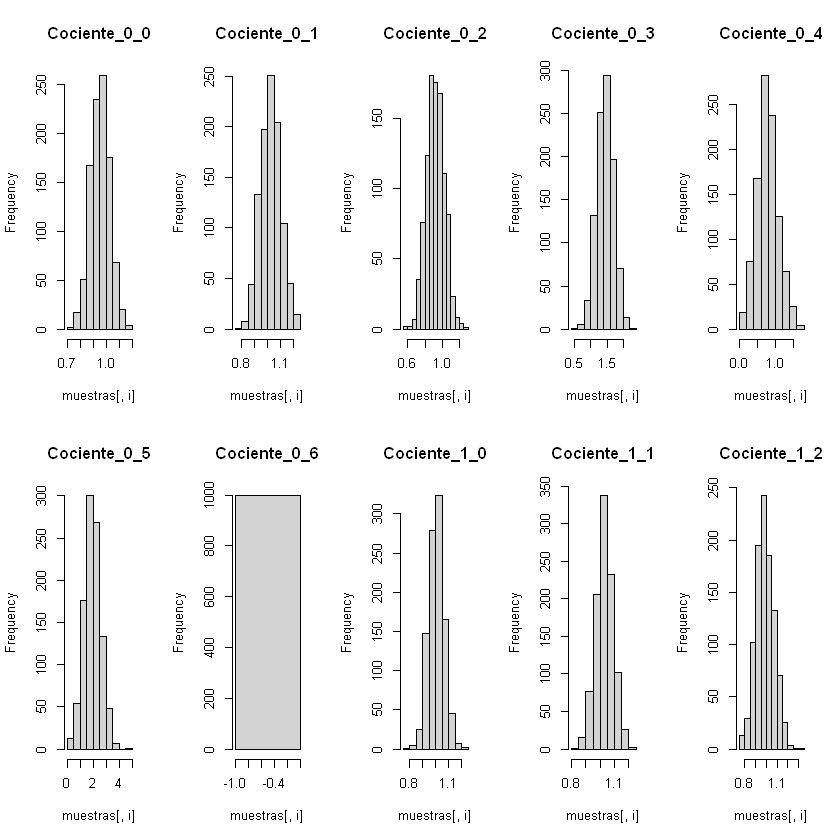

In [10]:
par(mfrow=c(2,5))
for(i in 1:10) hist(muestras[ , i], main = names(muestras)[i])

Por el teorema central del límite podemos aproximar la distribución de cada cociente a una normal, así que podemos hacer una prueba de hipotesis y ver si su media es 1.

$$H_0: \mu = 1 $$
$$H_1: \mu \neq 1 $$

In [11]:
# Suponiendo que la normalización es una buena aproximación y como n > 30 haremos
# una prueba de dos colas con:
# H_0: mu = 1, H_1: mu != 1
alpha <- 0.05

prueba_dos_colas <- function(ma_cociente, mu = 1){
    n <- length(ma_cociente)
    
    # Prueba
    estadistico <- (mean(ma_cociente, na.rm = TRUE) - mu)/(sd(ma_cociente, na.rm = TRUE)/n**(1/2))
    pvalue <- pnorm(abs(estadistico), lower.tail = FALSE)*2    
    
    return(pvalue)
}

pruebas <- sapply(muestras, prueba_dos_colas)
(no_rechazo <- names(which(pruebas > alpha))) # Cocientes dónde no rechazamos

[1] "Cociente_3_3" "Cociente_6_1"

De todos los 63 cocientes que tenemos solo en dos no rechazamos (3_3 y 6_1) que tengan media igual a 1 y en todos los demás rechazamos $H_0$ por lo cual podemos decir que $X$ y $Y$ no son independientes. Esto puede deberse a que la cantidad de goles del equipo contrario afecte moralmente al otro equipo ya sea postiva o negativamente.

Veamos los histogramas de los cocientes dónde no rechazamos que su media sea igual a 1. Podemos ver que ambas están centradas en 1 la cual puede ser la razón de no haber rechazado.

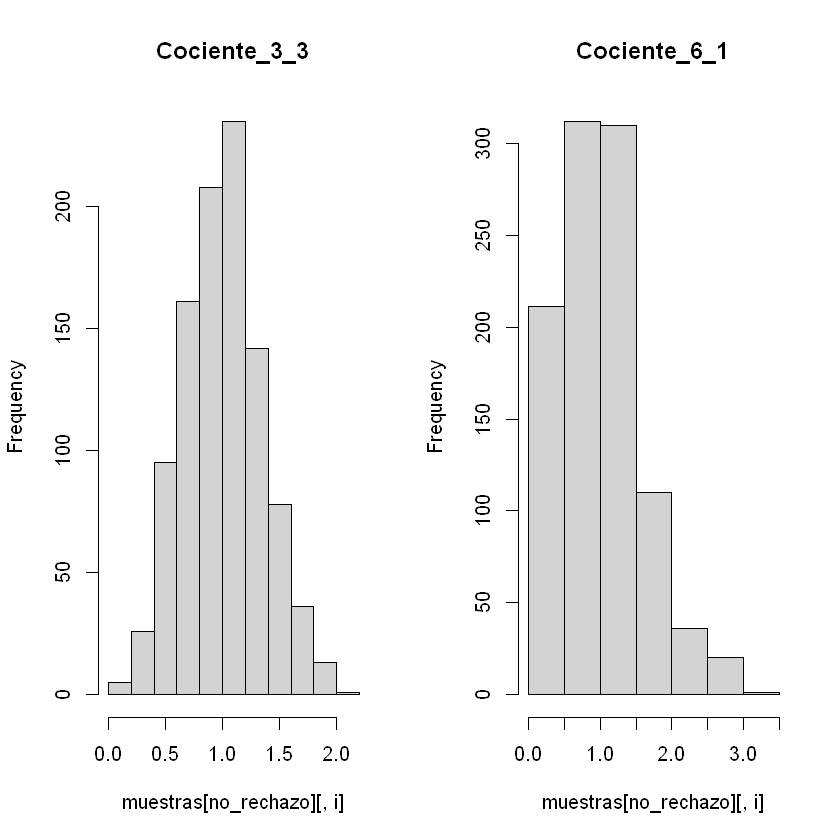

In [12]:
par(mfrow=c(1,2))
for(i in 1:2) hist(muestras[no_rechazo][ , i], main = names(muestras[no_rechazo])[i])